# Add calculated columns to three datasets

In [18]:
cd "C:\\Graduate courses\\s2\\Machine Learning\\Final Report"

C:\Graduate courses\s2\Machine Learning\Final Report


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
tickets = pd.read_csv('anonymized_hubspot_tickets.csv')
deals = pd.read_csv('anonymized_hubspot_deals.csv')
companies = pd.read_csv('anonymized_hubspot_companies.csv')

C:\Users\zhaos\AppData\Local\Temp\ipykernel_29096\1600953339.py:7: DtypeWarning: Columns (24,25,28,32,45) have mixed types. Specify dtype option on import or set low_memory=False.
  companies = pd.read_csv('anonymized_hubspot_companies.csv')


companies additional columns

In [20]:
# --- Company Size Category ---
def size_category(num_employees):
    if pd.isnull(num_employees):
        return np.nan
    elif num_employees < 10:
        return "Very Small"
    elif num_employees < 50:
        return "Small"
    elif num_employees < 250:
        return "Medium"
    elif num_employees < 1000:
        return "Large"
    else:
        return "Enterprise"

companies['Company_Size_Category'] = companies['Number of Employees'].apply(size_category)

# --- Revenue Category ---
def revenue_category(revenue):
    if pd.isnull(revenue):
        return np.nan
    elif revenue < 1_000_000:
        return "<$1M"
    elif revenue < 10_000_000:
        return "$1M-$10M"
    elif revenue < 50_000_000:
        return "$10M-$50M"
    elif revenue < 100_000_000:
        return "$50M-$100M"
    elif revenue < 500_000_000:
        return "$100M-$500M"
    else:
        return ">$500M"

companies['Revenue_Category'] = companies['Annual Revenue'].apply(revenue_category)

# --- Industry Standardized ---
companies['Industry_Standardized'] = companies['Industry'].str.title()

# --- Region ---
companies['Region'] = companies['Country/Region'].str.strip()

# --- Uses_[Technology] flags ---
technology_keywords = ['Google Tag Manager', 'Salesforce', 'Microsoft Office 365']
for tech in technology_keywords:
    col_name = f'Uses_{tech.replace(" ", "_")}'
    companies[col_name] = companies['Web Technologies'].fillna('').apply(lambda x: int(tech.lower() in x.lower()))

# --- Technology Count ---
companies['Technology_Count'] = companies['Web Technologies'].fillna('').apply(lambda x: len([t for t in x.split(';') if t.strip()]))

# --- Is_BPO flag ---
companies['Is_BPO'] = companies['BPO'].str.lower().map({'yes': 1, 'no': 0})

# --- Date-based Fields ---
companies['Create Date'] = pd.to_datetime(companies['Create Date'], errors='coerce')
companies['Create_Year'] = companies['Create Date'].dt.year
companies['Create_Month'] = companies['Create Date'].dt.month
companies['Create_Quarter'] = companies['Create Date'].dt.quarter
companies['Create_YearMonth'] = companies['Create Date'].dt.to_period('M').astype(str)


tickets additional columns

In [21]:
# Clean up column names just in case
tickets.columns = tickets.columns.str.strip()

# --- Convert date columns (only those that exist) ---
date_cols = [
    'Create date', 'Close date', '1st Syms presented for review',
    '1st syms run in production',  # This column may still not exist; remove if needed
]
for col in date_cols:
    if col in tickets.columns:
        tickets[col] = pd.to_datetime(tickets[col], errors='coerce')

# --- Implementation Duration in Days ---
tickets['Implementation_Duration_Days'] = (
    tickets['Close date'] - tickets['Create date']
).dt.days

# --- Days to First Sym ---
tickets['Days_To_First_Sym'] = (
    tickets['1st Syms presented for review'] - tickets['Create date']
).dt.days

# --- Time to Close in Hours ---
def convert_to_hours(x):
    try:
        h, m, s = map(int, str(x).split(':'))
        return h + m/60 + s/3600
    except:
        return np.nan

tickets['Time_To_Close_Hours'] = tickets['Time to close (HH:mm:ss)'].apply(convert_to_hours)

# --- Implementation Status (simplified) ---
status_map = {
    'New': 'Not Started',
    'In Progress': 'Ongoing',
    'Waiting on contact': 'Ongoing',
    'Waiting on us': 'Ongoing',
    'Closed': 'Completed'
}
tickets['Implementation_Status'] = tickets['Ticket status'].map(status_map)

# --- Training Completion Count & Percentage ---
training_cols = [
    'Training: Sym Building 101',
    'Training: Sym Building 201',
    'Training: General Overview',
    'Training: Reporting',
    'Training: Deployment/User Management Training'
]
tickets['Training_Completion_Count'] = tickets[training_cols].notna().sum(axis=1)
tickets['Training_Completion_Pct'] = (tickets['Training_Completion_Count'] / len(training_cols)) * 100

# --- Create Year, Month, YearMonth ---
tickets['Create_Year'] = tickets['Create date'].dt.year
tickets['Create_Month'] = tickets['Create date'].dt.month
tickets['Create_YearMonth'] = tickets['Create date'].dt.to_period('M').astype(str)


deals additional columns

In [22]:
# Strip column names just in case
deals.columns = deals.columns.str.strip()

# --- Parse date columns ---
deals['Create Date'] = pd.to_datetime(deals['Create Date'], errors='coerce')
deals['Close Date'] = pd.to_datetime(deals['Close Date'], errors='coerce')

# --- Create Year/Month/Quarter ---
deals['Create_Year'] = deals['Create Date'].dt.year
deals['Create_Month'] = deals['Create Date'].dt.month
deals['Create_Quarter'] = deals['Create Date'].dt.quarter

deals['Close_Year'] = deals['Close Date'].dt.year
deals['Close_Month'] = deals['Close Date'].dt.month

# --- YearMonth string for time-based grouping ---
deals['YearMonth'] = deals['Create Date'].dt.to_period('M').astype(str)

# --- Deal Size Category ---
def deal_size_category(amount):
    if pd.isnull(amount):
        return None
    elif amount < 10000:
        return "Small"
    elif amount < 50000:
        return "Medium"
    elif amount < 250000:
        return "Large"
    else:
        return "Enterprise"

deals['Deal_Size_Category'] = deals['Amount'].apply(deal_size_category)



# Merge deals and companies

In [23]:
import json

# Load the mappings file
with open('mappings.json', 'r') as f:
    mappings = json.load(f)

# Get the company-to-deal mappings
company_to_deals = mappings["CompanyToDeals"]

# Reverse the mapping to create a deal-to-company dictionary
# This will give a one-to-one mapping from deal ID to company ID
deal_to_company = {}

for company_id, deal_list in company_to_deals.items():
    for deal_id in deal_list:
        deal_to_company[deal_id] = company_id

# Assuming your deals dataset is already loaded and has a unique ID column
# Convert the deal ID column to string type for mapping
deals['Deal ID'] = deals['Record ID'].astype(str)

# Create a company ID column in the deals dataset using the deal_to_company dictionary
deals['Deal_Company_ID'] = deals['Deal ID'].map(deal_to_company)

# Convert company Record ID to string for merging
companies['Company ID'] = companies['Record ID'].astype(str)

# Merge the deals dataframe with the companies dataframe
# Using left join to keep all deals, even if there's no matching company
merged_deals_companies = pd.merge(
    left=deals, 
    right=companies, 
    left_on='Deal_Company_ID', 
    right_on='Company ID', 
    how='left'
)

# Now you have a merged dataset with deal information and corresponding company information

In [24]:
import json

# Load the mappings file
with open('mappings.json', 'r') as f:
    mappings = json.load(f)

# Get the company-to-deal mappings
company_to_deals = mappings["CompanyToDeals"]

# Reverse the mapping to create a deal-to-company dictionary
deal_to_company = {}
for company_id, deal_list in company_to_deals.items():
    for deal_id in deal_list:
        deal_to_company[deal_id] = company_id

# Convert the deal ID column to string type for mapping
deals['Deal ID'] = deals['Record ID'].astype(str)
deals['Deal_Company_ID'] = deals['Deal ID'].map(deal_to_company)

# Convert company Record ID to string for merging
companies['Company ID'] = companies['Record ID'].astype(str)

# 1. Find columns with the same name in both dataframes (excluding join keys)
deal_cols = set(deals.columns)
company_cols = set(companies.columns)
join_keys = {'Record ID', 'Deal ID', 'Deal_Company_ID', 'Company ID'}

overlap = (deal_cols & company_cols) - join_keys

# 2. Rename columns
deals_renamed = deals.rename(
    columns={col: f'Deal_{col}' for col in overlap}
)
companies_renamed = companies.rename(
    columns={col: f'Company_{col}' for col in overlap}
)

# Make sure to also rename the join keys back after merge, if needed
merged_deals_companies = pd.merge(
    left=deals_renamed,
    right=companies_renamed,
    left_on='Deal_Company_ID',
    right_on='Company ID',
    how='left'
)



In [25]:
cd "C:\Graduate courses\s2\Machine Learning\Final Report\output"

C:\Graduate courses\s2\Machine Learning\Final Report\output


In [44]:
merged_deals_companies.to_csv('merged_deals_companies.csv', index=False)

# Data Cleaning

Drop columns with >90% missing

In [26]:
def drop_high_na_columns(df, threshold=0.90):
    return df.loc[:, df.isnull().mean() <= threshold]

merged_cleaned = drop_high_na_columns(merged_deals_companies)


In [27]:
print(merged_cleaned.columns)

Index(['Weighted amount', 'Deal Description',
       'Cumulative time in "BANT Deal. Pain ID'ed (Sales Pipeline)" (HH:mm:ss)',
       'Days to close', 'Deal Score', 'Deal_Close Date',
       'Deal source attribution 2', 'Contract Start Date', 'Pipeline',
       'Record ID_x', 'Forecast category', 'Original Traffic Source',
       'Deal_Associated Company', 'Deal owner', 'Is Closed (numeric)',
       'Amount in company currency', 'Deal probability',
       'Associated Company (Primary)', 'Is Closed Won',
       'Deal_Contract End Date', 'Last Activity Date',
       'Contract Term (Months)', 'Is closed lost',
       'Weighted amount in company currency', 'Is Deal Closed?', 'Deal Name',
       'Amount', 'Forecast amount',
       'Cumulative time in "Negotiation (Sales Pipeline)" (HH:mm:ss)',
       'Is Open (numeric)', 'Deal_Create Date',
       'Cumulative time in "Contract Sent (Sales Pipeline)" (HH:mm:ss)',
       'Deal_Last Modified Date', 'Deal Stage', 'Deal Type',
       'Deal_Creat

Keep relevant columns

In [28]:
columns_to_remove = [
    'Pipeline',
    'Forecast category',
    'Forecast Amount',
    'CCaaS',
    'Number of Form Submissions',
    'Web Technologies',
    'Deal probability',
    'Forecast amount',
    'ICP Fit Level',
    'ICP',
    'BPO',
    'WFM',
    'Uses_Google_Tag_Manager',
    'Associated Contact',
    'Uses_Salesforce',
    'Uses_Microsoft_Office_365',
    'Segmentation',
    'Number of Pageviews', 
    'Year Founded',
    'Record ID_x',
    'Record ID_y',
    'Deal_Company_ID',
    'Deal Description',
    'Time Zone'
]
merged_cleaned.drop(columns=columns_to_remove, inplace=True, errors='ignore')

C:\Users\zhaos\AppData\Local\Temp\ipykernel_29096\2311890910.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_cleaned.drop(columns=columns_to_remove, inplace=True, errors='ignore')


# Customer Segmentation

Here are some features I want to use:
- Number of times contacted
- # of Agents Contracted
- Industry_Standardized
- Revenue_Category
- Company_Size_Category
- Region (US or not)
- Technology_Count
- Last Activity Date
- Weighted amount in company currency (This is the expected value of the deal, adjusted for probability of closing. Because not all deals will close, companies use "weighted amount" to estimate realistic expected revenue.)
- Deal Stage
- Deal Type
- Days to close
- Deal source attribution 2 (Referral and others)
- Is Closed (numeric) (only contains those already closed)
- Is Closed Won
- Is closed lost

# Further Data Cleaning for Customer Segmentation

Make additional columns for Region (US or not) and Deal source attribution 2 (Referral and others), only keep those columns that I mentioned

In [29]:
merged_cleaned["Region_bin"] = merged_cleaned["Region"].str.contains("United States", case=False, na=False).astype(int)

merged_cleaned["Referral_flag"] = merged_cleaned["Deal source attribution 2"].str.contains("Referral", case=False, na=False).astype(int)


C:\Users\zhaos\AppData\Local\Temp\ipykernel_29096\924662386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_cleaned["Region_bin"] = merged_cleaned["Region"].str.contains("United States", case=False, na=False).astype(int)
C:\Users\zhaos\AppData\Local\Temp\ipykernel_29096\924662386.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_cleaned["Referral_flag"] = merged_cleaned["Deal source attribution 2"].str.contains("Referral", case=False, na=False).astype(int)


In [ ]:
merged_cleaned.to_csv('merged_cleaned.csv', index=False)

In [30]:
columns_to_keep = [
    'Number of times contacted',
    '# of Agents Contracted',
    'Industry_Standardized',
    'Revenue_Category',
    'Company_Size_Category',
    'Region_bin',
    'Technology_Count',
    'Weighted amount in company currency',
    'Last Activity Date',
    'Deal Stage',
    'Deal Type',
    'Days to close',
    'Referral_flag',
    'Is Closed (numeric)',
    'Is Closed Won',
    'Is closed lost'
]

merged_cleaned = merged_cleaned[columns_to_keep]

In [35]:
merged_cleaned.to_csv('merged_cleaned_cs.csv', index=False)

1. RFM Segmentation (Recency, Frequency, Monetary)
- Use:

- Recency: Days to close (lower = more recent activity)

- Frequency: Number of times contacted

- Monetary: Weighted amount in company currency

- You can cluster customers into:

- High-value & engaged

- Low-value but frequent

- Dormant but once high-value


In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- 1. Load dataset ---------------------------------------------------------
df = pd.read_csv("merged_cleaned_cs.csv")
df.columns = df.columns.str.strip()  # remove any extra spaces

# --- 2. Parse 'Last Activity Date' and compute Recency -----------------------
df["Last Activity Date"] = pd.to_datetime(df["Last Activity Date"], errors='coerce', infer_datetime_format=True)
today = pd.Timestamp.today()
df["Recency"] = (today - df["Last Activity Date"]).dt.days

# --- 3. Select and rename RFM columns ----------------------------------------
rfm_df = df[["Recency", "Number of times contacted", "Weighted amount in company currency"]].copy()
rfm_df.columns = ["Recency", "Frequency", "Monetary"]

# --- 4. Handle missing values ------------------------------------------------
rfm_df.fillna(rfm_df.median(numeric_only=True), inplace=True)

# --- 5. Normalize RFM values -------------------------------------------------
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df)

# --- 6. KMeans Clustering (elbow method shown earlier) -----------------------
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_df["Segment"] = kmeans.fit_predict(rfm_scaled)

# --- 7. Reverse-transform cluster centers to interpret -----------------------
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=["Recency", "Frequency", "Monetary"]
)

# --- 8. Auto-label each cluster ----------------------------------------------
def label_segment(row):
    if row["Recency"] < rfm_df["Recency"].median() and row["Monetary"] > rfm_df["Monetary"].median():
        return "High-Value Engaged"
    elif row["Recency"] > rfm_df["Recency"].median() and row["Monetary"] > rfm_df["Monetary"].median():
        return "Dormant but High-Value"
    elif row["Frequency"] > rfm_df["Frequency"].median():
        return "Frequent Low Spender"
    else:
        return "Low-Value Passive"

cluster_centers["Label"] = cluster_centers.apply(label_segment, axis=1)

# --- 9. Assign labels to each customer ---------------------------------------
label_dict = dict(zip(range(optimal_k), cluster_centers["Label"]))
rfm_df["Segment_Label"] = rfm_df["Segment"].map(label_dict)

# --- 10. Save segmented result (optional) ------------------------------------
rfm_df.to_csv("rfm_segmented.csv", index=False)

# --- 11. View summarized segmentation -----------------------------------------
segment_summary = rfm_df.groupby("Segment_Label").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean",
    "Segment_Label": "count"
}).rename(columns={"Segment_Label": "Count"})

print(segment_summary)


C:\Users\zhaos\AppData\Local\Temp\ipykernel_29096\809915148.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["Last Activity Date"] = pd.to_datetime(df["Last Activity Date"], errors='coerce', infer_datetime_format=True)


                           Recency     Frequency      Monetary  Count
Segment_Label                                                        
Dormant but High-Value  569.116071    218.169643   6362.946429    112
Frequent Low Spender    131.166667  15726.000000      0.000000      3
High-Value Engaged      175.792887    340.956067  17450.949791    478


Performance

In [39]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# --- Use scaled data (rfm_scaled) and assigned cluster labels ----------------
labels = rfm_df["Segment"]

# 1. Silhouette Score (higher is better, range: -1 to 1)
silhouette = silhouette_score(rfm_scaled, labels)

# 2. Calinski-Harabasz Index (higher is better)
calinski = calinski_harabasz_score(rfm_scaled, labels)

# 3. Davies-Bouldin Index (lower is better)
davies = davies_bouldin_score(rfm_scaled, labels)

# --- Print performance summary ------------------------------------------------
print("Clustering Performance Metrics:")
print(f"🔹 Silhouette Score:         {silhouette:.3f}")
print(f"🔹 Calinski-Harabasz Index:  {calinski:.2f}")
print(f"🔹 Davies-Bouldin Index:     {davies:.3f}")


Clustering Performance Metrics:
🔹 Silhouette Score:         0.593
🔹 Calinski-Harabasz Index:  528.32
🔹 Davies-Bouldin Index:     0.460


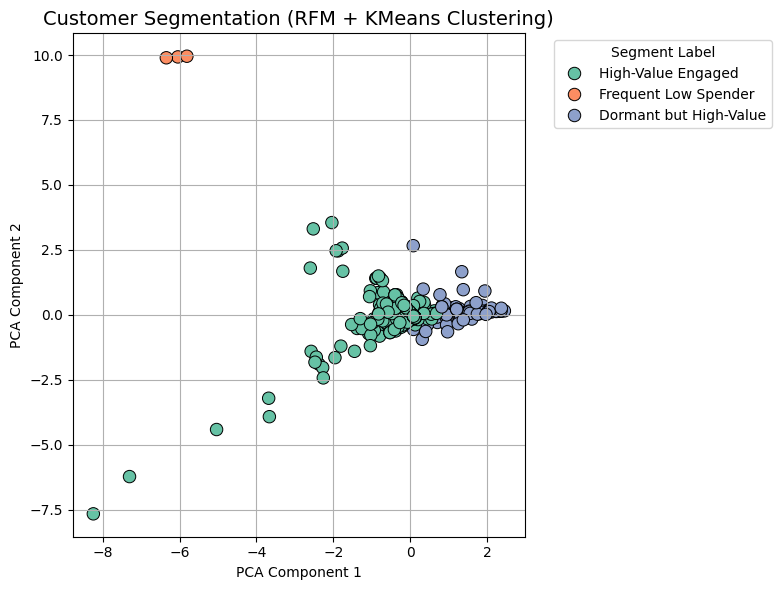

In [40]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Perform PCA to reduce RFM features to 2 dimensions -------------------
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Add PCA components back to DataFrame for plotting
rfm_df["PCA1"] = rfm_pca[:, 0]
rfm_df["PCA2"] = rfm_pca[:, 1]

# --- 2. Plot clusters with Seaborn scatter plot ------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm_df,
    x="PCA1",
    y="PCA2",
    hue="Segment_Label",
    palette="Set2",
    s=80,
    edgecolor="black"
)
plt.title("Customer Segmentation (RFM + KMeans Clustering)", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Segment Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


📊 What the PCA Plot Shows:
Each dot = one customer
Each color = a segment label (cluster)
Position = compressed summary of RFM values (Recency, Frequency, Monetary)
The axes (PCA1, PCA2) don’t represent physical quantities — they summarize variation in all three RFM dimensions.

🔍 Segment Interpretation:
🟢 High-Value Engaged
Densely clustered in the middle-left

These customers:

Have low Recency (recently active)

Have high Monetary (spend a lot)

Have moderate-to-high Frequency

📌 Action: Prioritize them — they're your most valuable customers!

🟠 Frequent Low Spender
Few points in the top-left corner

These customers:

Contact a lot (high Frequency)

Spend almost nothing (low Monetary)

Recency may vary

📌 Action: Consider upselling/cross-selling to improve their value

🔵 Dormant but High-Value
Located toward the right

These customers:

Haven’t interacted recently (high Recency)

Used to spend well (high Monetary)

May have average or low contact frequency

📌 Action: Re-engage via targeted campaigns or loyalty incentives

🧠 How to Use This:
Tailor marketing strategies per segment

Personalize email campaigns

Prioritize sales efforts

Track how clusters shift over time (e.g., dormant → engaged)

2. Behavioral Segmentation
- Based on:

- # of Agents Contracted

- Technology_Count

- Referral_flag

- Is Closed Won vs. Is closed lost

- Use clustering (e.g. KMeans or Hierarchical) to discover behavior-based groups like:

- Tech-savvy frequent referrers

- High-contact but low-conversion prospects

- Referral-only passive deals

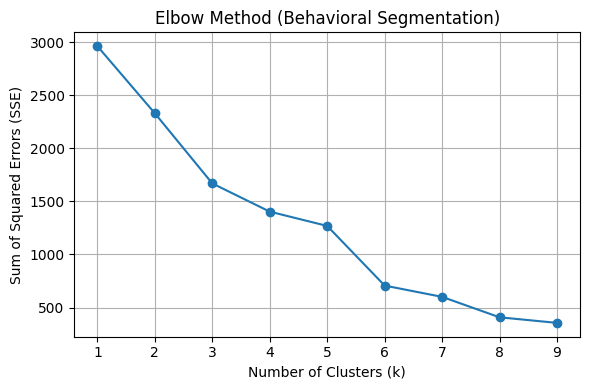

In [42]:
# --- 1. Select behavioral segmentation features ------------------------------
behavior_df = df[[
    "# of Agents Contracted",
    "Technology_Count",
    "Referral_flag",
    "Is Closed Won",
    "Is closed lost"
]].copy()

# --- 2. Handle missing values ------------------------------------------------
behavior_df.fillna(behavior_df.median(numeric_only=True), inplace=True)

# --- 3. Normalize the features -----------------------------------------------
scaler_behavior = StandardScaler()
behavior_scaled = scaler_behavior.fit_transform(behavior_df)

# --- 4. Use Elbow Method to determine optimal k ------------------------------
sse_behavior = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(behavior_scaled)
    sse_behavior.append(kmeans.inertia_)

# --- 5. Plot the Elbow curve -------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(range(1, 10), sse_behavior, marker='o')
plt.title("Elbow Method (Behavioral Segmentation)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.grid(True)
plt.tight_layout()
plt.show()


,DBSCAN_Cluster,Count
0,-1,24
1,0,47
2,1,99
3,2,65
4,3,80
5,4,44
6,5,19
7,6,8
8,7,32
9,8,6


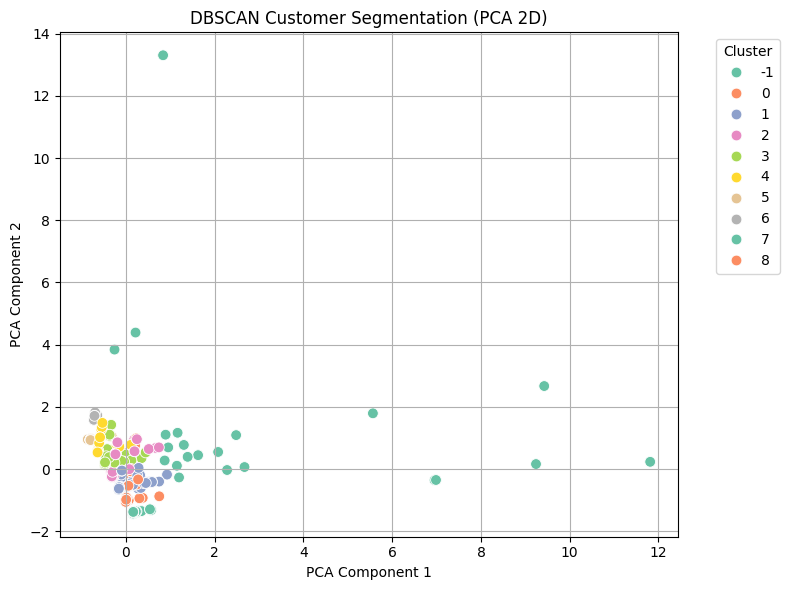

In [71]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display

# --- 1. Filter rows where deal is closed -------------------------------------
closed_df = df[df["Is Closed (numeric)"] == 1].copy()

# --- 2. Select relevant features ---------------------------------------------
dbscan_features = [
    "Revenue_Category",
    "Weighted amount in company currency",
    "Number of times contacted",
    "# of Agents Contracted"
]

dbscan_df = closed_df[dbscan_features].copy()

# --- 3. Encode 'Revenue_Category' if needed ----------------------------------
if dbscan_df["Revenue_Category"].dtype == 'object':
    le = LabelEncoder()
    dbscan_df["Revenue_Category"] = le.fit_transform(dbscan_df["Revenue_Category"].astype(str))

# --- 4. Fill missing values --------------------------------------------------
dbscan_df.fillna(dbscan_df.median(numeric_only=True), inplace=True)

# --- 5. Normalize the data ---------------------------------------------------
scaler = StandardScaler()
dbscan_scaled = scaler.fit_transform(dbscan_df)

# --- 6. Run DBSCAN -----------------------------------------------------------
dbscan_model = DBSCAN(eps=0.61, min_samples=5)  # Try changing eps (e.g., 0.5, 1.0, 1.5)
dbscan_labels = dbscan_model.fit_predict(dbscan_scaled)
dbscan_df["DBSCAN_Cluster"] = dbscan_labels

# --- 7. Show cluster counts --------------------------------------------------
dbscan_cluster_counts = dbscan_df["DBSCAN_Cluster"].value_counts().sort_index()
dbscan_cluster_counts.name = "Count"
dbscan_cluster_counts = dbscan_cluster_counts.reset_index().rename(columns={"index": "Cluster"})
display(dbscan_cluster_counts)

# --- 8. Optional: 2D PCA Visualization ---------------------------------------
pca = PCA(n_components=2)
pca_components = pca.fit_transform(dbscan_scaled)
dbscan_df["PCA1"] = pca_components[:, 0]
dbscan_df["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=dbscan_df, x="PCA1", y="PCA2", hue="DBSCAN_Cluster", palette="Set2", s=60)
plt.title("DBSCAN Customer Segmentation (PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from IPython.display import display

# Replace ace_tools.display_dataframe_to_user with this
display(dbscan_cluster_counts)